# Travaux pratique: Filtrage et Restauration

**Prénom et nom:** Alice Valença De Lorenci

In [1]:
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio


# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max
#%% SECTION 2 fonctions utiles pour le TP

In [2]:
def viewimage(im, normalise=True, MINI=0.0, MAXI=255.0, show=False):
    """ 
    Cette fonction fait afficher l'image EN NIVEAUX DE GRIS.
    Par defaut normalise=True. Et dans ce cas l'image est normalisee 
    entre 0 et 255. 
    Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat.
    """
    
    if len(im.shape) > 2:
        print( "Expected a single channel image but found: {}".format( im.shape ) )
        
    imt=np.float32(im.copy())
    
    if normalise:
        m=im.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    if show:
        plt.imshow(imt, cmap='gray')
        plt.axis('off')
        plt.show()
        return
    else:
        return imt

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0, show=False):
    """ 
    Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
    dans gimp. Si un gimp est deja ouvert il est utilise.
    Par defaut normalise=True. Et dans ce cas l'image est normalisee 
    entre 0 et 255 avant d'Ãªtre sauvegardee.
    Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
    """
    
    imt=np.float32(im.copy())
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
        
    if show:
        plt.imshow(imt)
        plt.axis('off')
        plt.show()
        return
    else:
        return imt

## 2. Transformation géométrique

In [3]:
def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    """
   %
%Effectue la transformation geometrique d'une image par
%une rotation + homothetie 
%
% x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
% y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0 
%
% theta : angle de rotation en degres
% alpha : facteur d'homothetie (defaut=1)
% x0, y0 : centre de la rotation (defaut=centre de l'image)
% ech : plus proche voisin (defaut=0) ou bilineaire (1)
% clip : format de l'image originale (defaut=True), image complete (False)
% 

    """ 
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire 
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

**Utiliser la fonction ```rotation``` pour transformer une image de votre choix. Quelle différence y-a-t-il
entre la méthode à plus proche voisin et la méthode bilinéaire?**

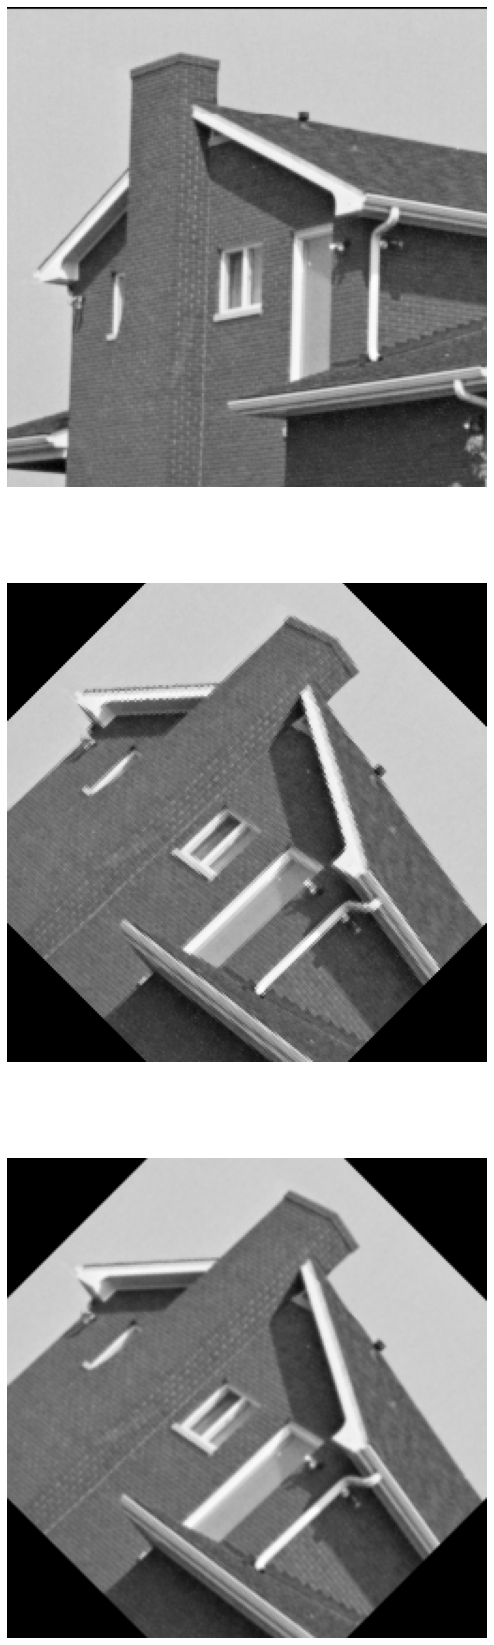

In [4]:
method = {'nn':0, 'bl':1}

im = skio.imread('../images/maison.tif')

im_nn = rotation( im, 45, ech=method['nn'] )
im_bl = rotation( im, 45, ech=method['bl'] )

fig, axs = plt.subplots(3, 1, figsize=(10, 30))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( im_nn ), cmap='gray' )
axs[2].imshow( viewimage( im_bl ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

**Que constatez-vous sur une image qui aurait subi huit rotations de 45 degrés (en bilinéaire et en
plus proche voisin)?**

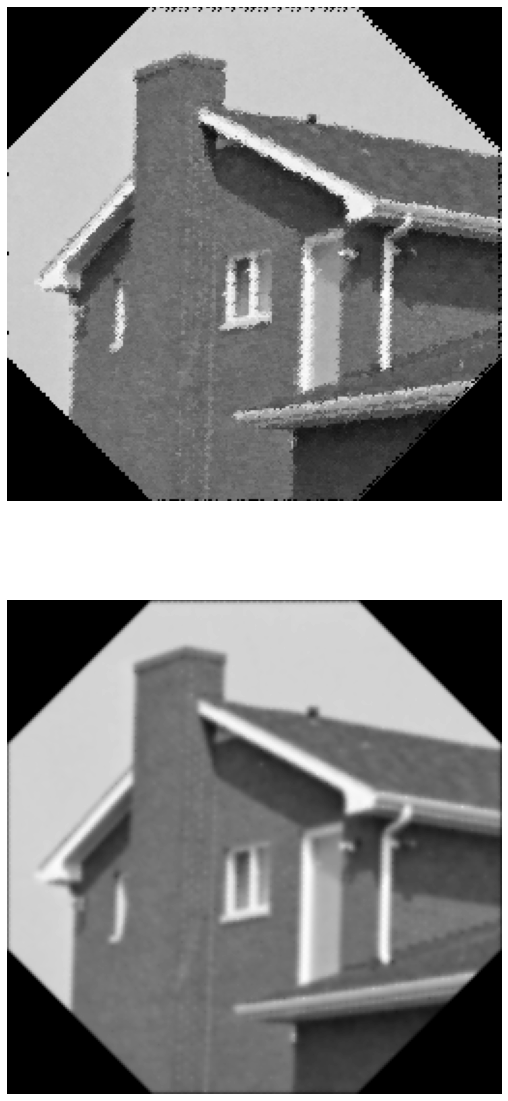

In [5]:
method = {'nn':0, 'bl':1}

im = skio.imread('../images/maison.tif')

im_8nn = im.copy()
im_8bl = im.copy()

for i in range(8):
    im_8nn = rotation( im_8nn, 45, ech=method['nn'] )
    im_8bl = rotation( im_8bl, 45, ech=method['bl'] )

fig, axs = plt.subplots(2, 1, figsize=(10, 20))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im_8nn ), cmap='gray' )
axs[1].imshow( viewimage( im_8bl ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

**Que constatez-vous si vous appliquez la rotation avec un facteur de zoom inférieur à 1 (par exemple
1/2)? Qu’aurait-il fallu faire pour atténuer l’effet constaté?**

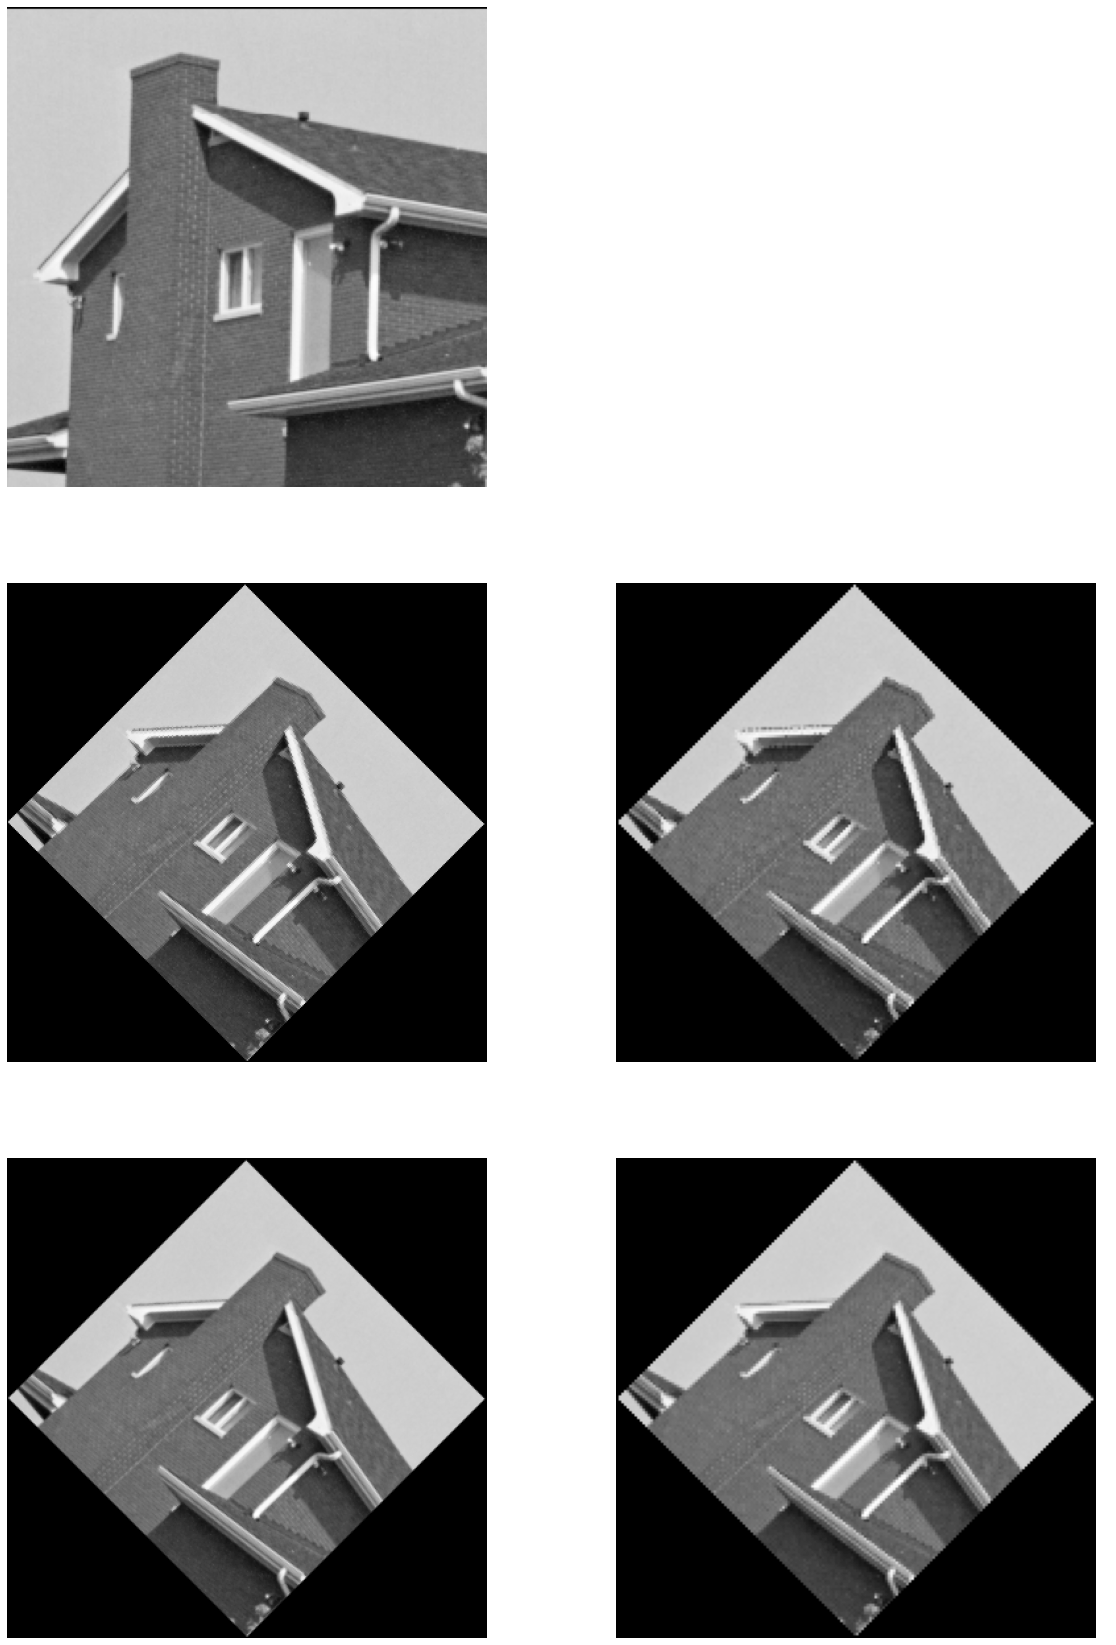

In [6]:
method = {'nn':0, 'bl':1}

im = skio.imread('../images/maison.tif')

im_nn = rotation( im, 45, ech=method['nn'], clip=False )
im_bl = rotation( im, 45, ech=method['bl'], clip=False )

im_nn05 = rotation( im, 45, alpha=0.5, ech=method['nn'], clip=False )
im_bl05 = rotation( im, 45, alpha=0.5, ech=method['bl'], clip=False )

fig, axs = plt.subplots(3, 2, figsize=(20, 30))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )

axs[2].imshow( viewimage( im_nn ), cmap='gray' )
axs[3].imshow( viewimage( im_nn05 ), cmap='gray' )

axs[4].imshow( viewimage( im_bl ), cmap='gray' )
axs[5].imshow( viewimage( im_bl05 ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

## Filtrage linéaire et médian

In [7]:
def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def median_filter(im,typ=1,r=1,xy=None):
    """ renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois. 
         """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

In [8]:
def noise(im, br):
    """ 
    Cette fonction ajoute un bruit blanc gaussier d'ecart type br
    a l'image im et renvoie le resultat
    """
    
    imt = np.float32(im.copy())
    sh = imt.shape
    bruit = br*np.random.randn(*sh)
    imt = imt + bruit
    return imt

In [9]:
def var_image(im,x0,y0,x1,y1):
    patch=im[y0:y1+1,x0:x1+1]
    return patch.var()

**Appliquer un filtrage médian à une image bruitée et comparer le résultat avec un filtrage
linéaire.**

In [10]:
get_gau_ker(1).shape

(5, 5)

In [11]:
get_cst_ker(5).shape

(5, 5)

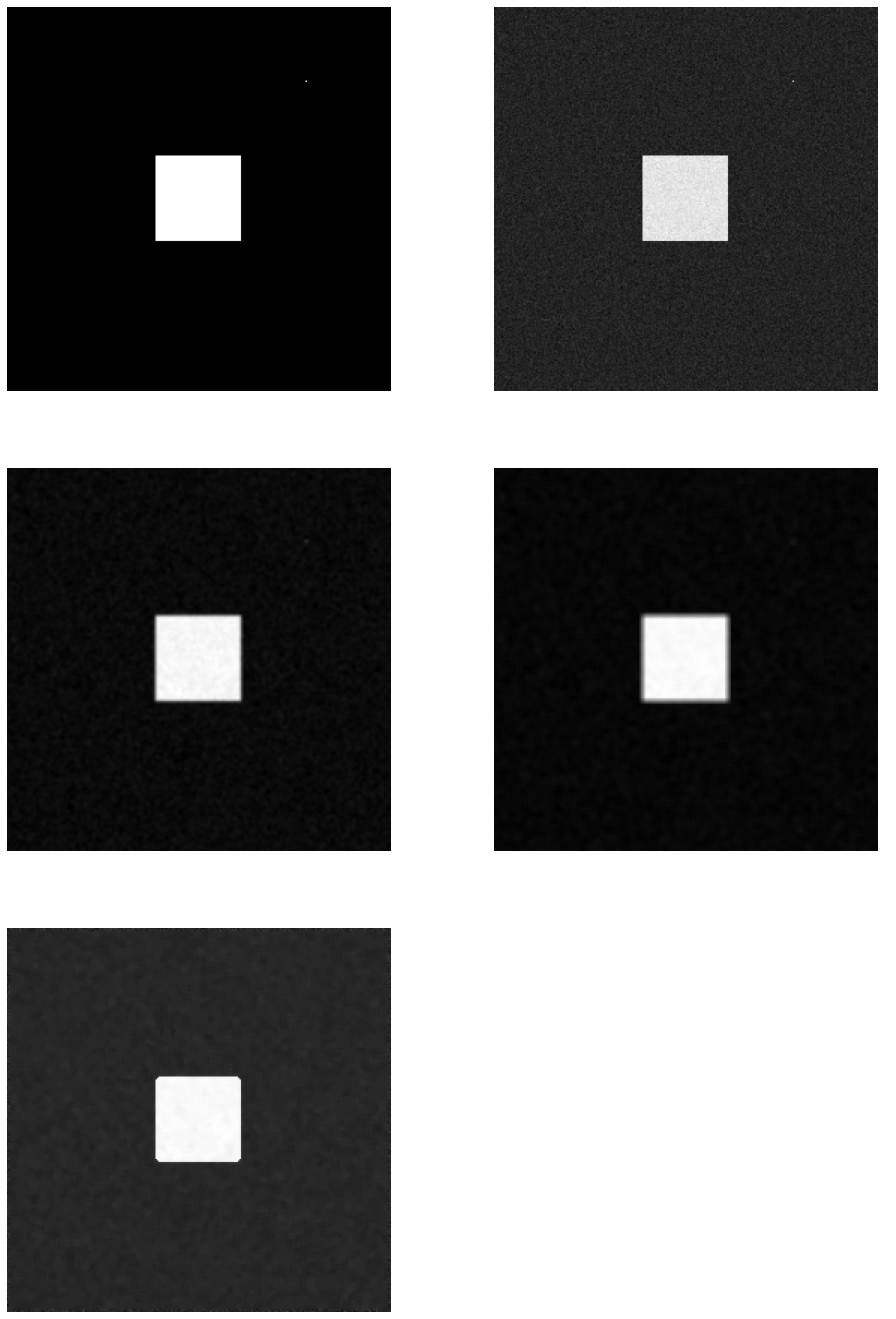

In [12]:
im = skio.imread('../images/carre_orig.tif')

imb = noise(im,10)

ker_g = get_gau_ker(1)
im_g = filtre_lineaire( imb, ker_g )

ker_c = get_cst_ker(5)
im_c = filtre_lineaire( imb, ker_c )

im_median = median_filter(imb, r=2)

fig, axs = plt.subplots(3, 2, figsize=(16, 24))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( imb ), cmap='gray' )
axs[2].imshow( viewimage( im_g ), cmap='gray' )    # gaussian kernel
axs[3].imshow( viewimage( im_c ), cmap='gray' )    # linear kernel
axs[4].imshow( viewimage( im_median ), cmap='gray') # median filter

for ax in axs:
    ax.axis('off')
    
plt.show()

In [13]:
# analysing the variance on the white central square

x0 = 0; y0 = 0; x1 = 10; y1 = 10

print( "Original image: ", var_image(im, x0, y0, x1, y1) )
print( "Noisy image: ", var_image(imb, x0, y0, x1, y1) )
print( "Gaussian filter: ", var_image(im_g, x0, y0, x1, y1) )
print( "Linear filter: ", var_image(im_c, x0, y0, x1, y1) )
print( "Median filter: ", var_image(im_median, x0, y0, x1, y1) )

Original image:  0.0
Noisy image:  112.99063104941165
Gaussian filter:  6.563407772903545
Linear filter:  2.799315948785142
Median filter:  51.10086849231547


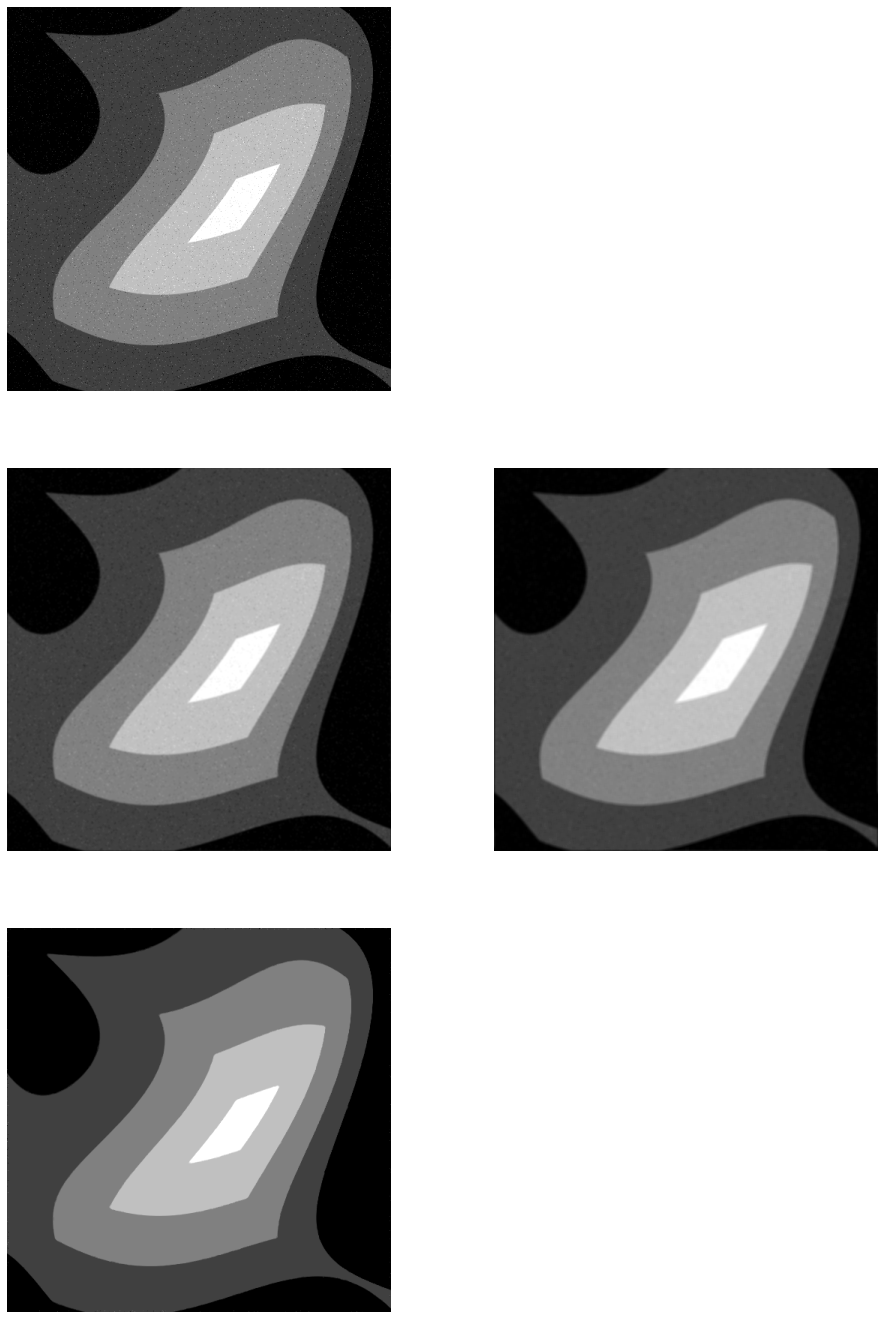

In [14]:
im = skio.imread('../images/pyra-impulse.tif')

ker_g = get_gau_ker(1)
im_g = filtre_lineaire( im, ker_g )

ker_c = get_cst_ker(5)
im_c = filtre_lineaire( im, ker_c )

im_median = median_filter(im, r=2)

fig, axs = plt.subplots(3, 2, figsize=(16, 24))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[2].imshow( viewimage( im_g ), cmap='gray' )    # gaussian kernel
axs[3].imshow( viewimage( im_c ), cmap='gray' )    # linear kernel
axs[4].imshow( viewimage( im_median ), cmap='gray') # median filter

for ax in axs:
    ax.axis('off')
    
plt.show()

## Restauration

In [26]:
def filtre_inverse(im,mask):
    """ renvoie l'inverse de mask applique a im.
    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)/fft2(mm))
    
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def wiener(im,K,lamb=0):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       lamb=0 donne le filtre inverse
       on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
       avec une regularisation qui permet de ne pas trop augmenter le bruit.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+lamb*w2)
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

**Appliquer un filtre linéaire à une image puis utilisez la fonction ```filtre inverse```. Que constatez-
vous? Que se passe-t-il si vous ajoutez très peu de bruit à l’image floutée avant de la restaurer
par la commade précédente?**

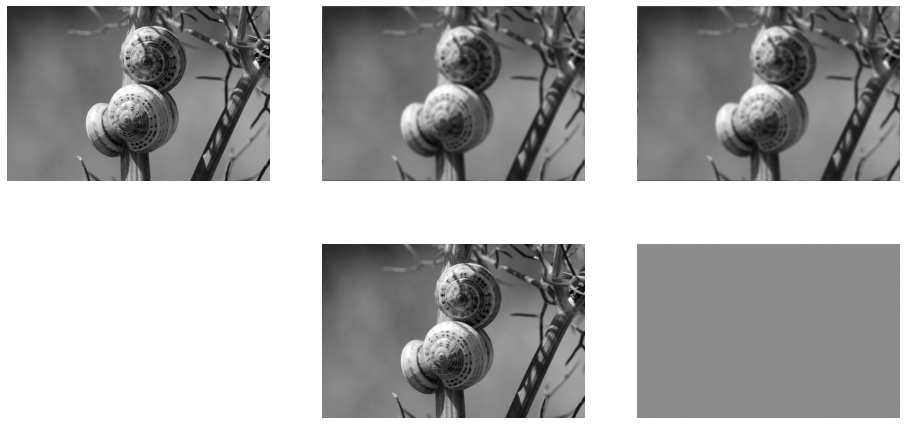

Distance between original image and recovered image (without noise):  1.6544543082957582e-07


In [34]:
im = skio.imread('../images/spirale.jpg').mean(axis=2)
# imb = noise(im,1)

ker = get_cst_ker(11)
im_filt = filtre_lineaire( im, ker )
im_filt_b = noise( im_filt, 1 )

im_rec = filtre_inverse( im_filt, ker )
im_rec_b = filtre_inverse( im_filt_b, ker )

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )

axs[1].imshow( viewimage( im_filt ), cmap='gray' )
axs[2].imshow( viewimage( im_filt_b ), cmap='gray' )

axs[4].imshow( viewimage( im_rec ), cmap='gray' )
axs[5].imshow( viewimage( im_rec_b ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

print( "Distance between original image and recovered image (without noise): ", np.linalg.norm( im - im_rec ) )

**Comment pouvez-vous déterminer le noyau de convolution qu’a subi l’image carre ```flou.tif```?**

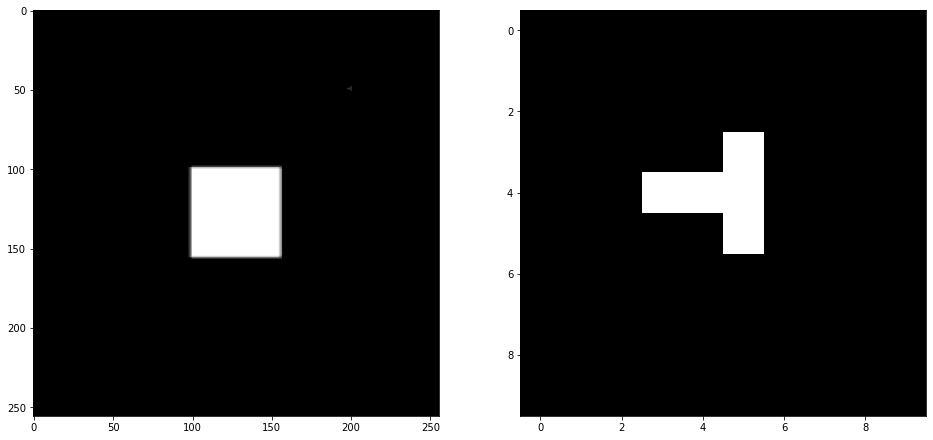

In [28]:
im = skio.imread('../images/carre_flou.tif')

fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( im[45:55,195:205], normalise=False ), cmap='gray' )

# for ax in axs:
#     ax.axis('off')
    
plt.show()

In [29]:
im[45:55,195:205]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 51,  0,  0,  0,  0],
       [ 0,  0,  0, 51, 51, 51,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 51,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint8)

In [30]:
ker = np.array( [[0,0,51],
                 [51,51,51],
                 [0,0,51]] ) 

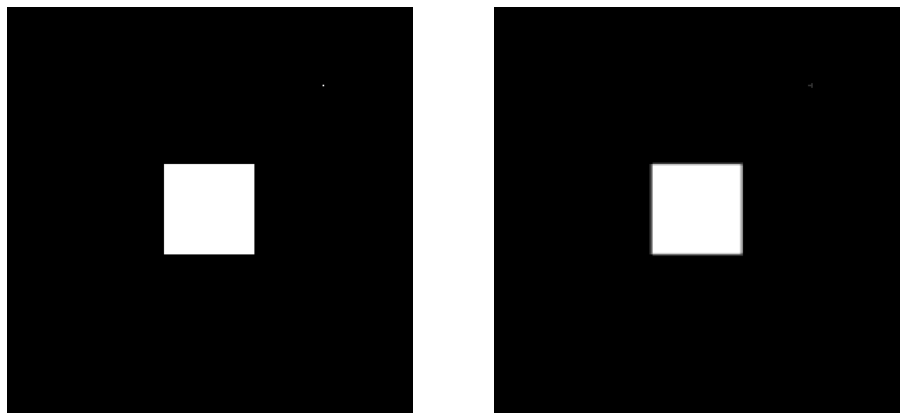

In [31]:
im = skio.imread('../images/carre_orig.tif')

imf = filtre_lineaire( im, ker )

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( imf ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

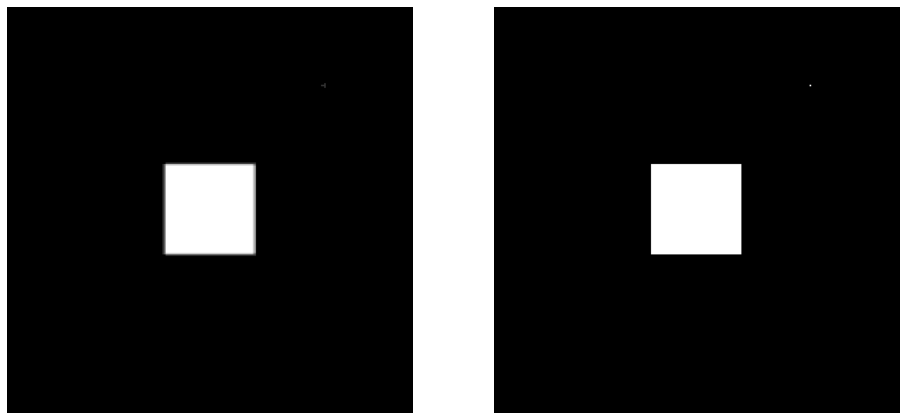

In [32]:
im = skio.imread('../images/carre_flou.tif')
im_rest = wiener(im,ker,lamb=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( im_rest ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()

**Après avoir ajouté du bruit à cette image utilisez la fonction ```wiener``` pour restaurer cette image. Faites varier le parametre $\lambda$ et commentez les résultats.**

0.000000e+00: 78.71918487548828
1.000000e+04: 33.981510162353516
1.000000e+05: 23.309873580932617
2.500000e+05: 16.022560119628906
5.000000e+05: 12.667174339294434
1.000000e+06: 8.50460433959961


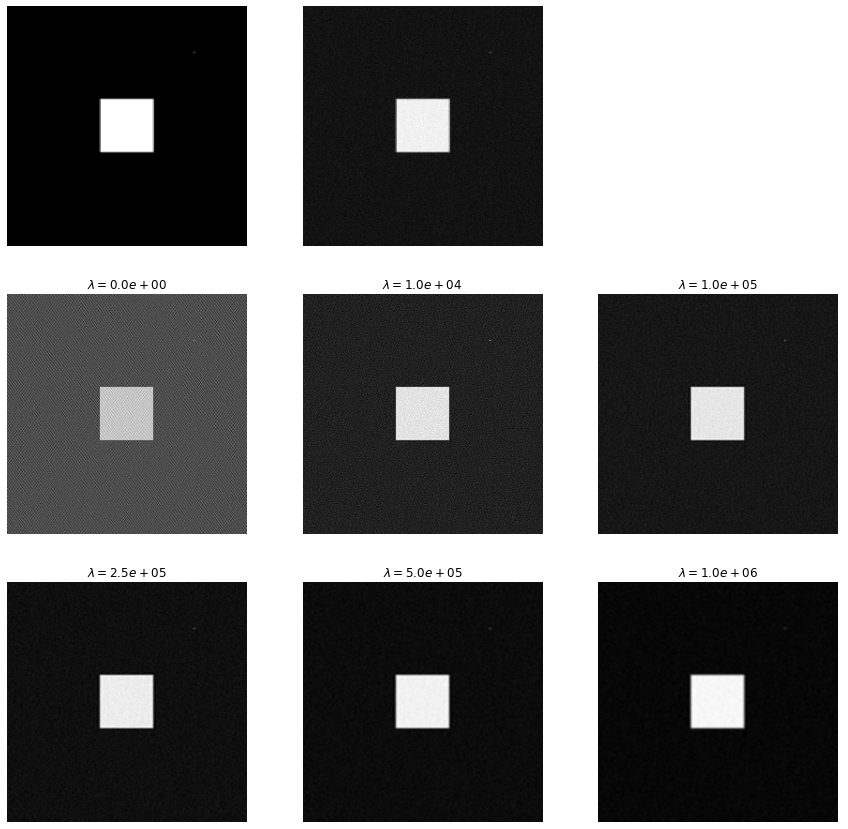

In [203]:
im = skio.imread('../images/carre_flou.tif')
imb = noise(im, 5)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( imb ), cmap='gray' )

lamb = [0, 1e4, 1e5, 2.5e5, 5e5, 1e6]
for i in range( len(lamb) ):
    im_rest = wiener( imb, ker, lamb=lamb[i] )
    
    axs[i+3].imshow( viewimage( im_rest ), cmap='gray' )
    axs[i+3].set_title( "$\lambda={:.1e}$".format(lamb[i]) )
    
    print( "{:e}: {}".format( lamb[i], np.linalg.norm( viewimage( im ) - viewimage( im_rest ) ) ) )

for ax in axs:
    ax.axis('off')
    
plt.show()

## Applications

### Comparaisons filtrage linéaire et médian

**Pour une image simple telle que ```carre_orig.tif``` et un bruit d’écart-type 5, trouver la taille du
noyau constant qui réduit le bruit dans les mêmes proportions qu’un filtre médian circulaire de rayon 4. (explicitez l’algorithme utilisé)**

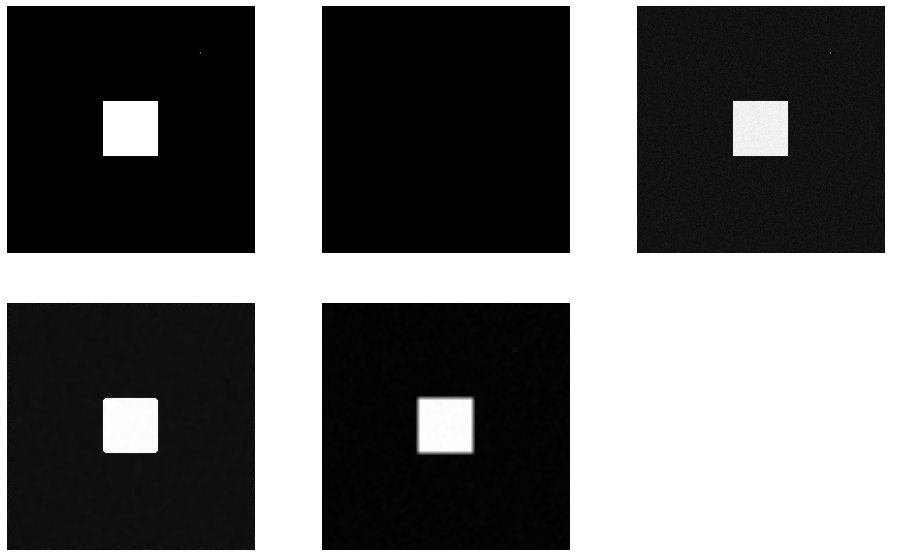

In [48]:
im = skio.imread('../images/carre_orig.tif')

x0 = 0; y0 = 0; x1 = 10; y1 = 10
im_hom = im[x0:x1,y0:y1]

imb = noise(im,5)

# ker_g = get_gau_ker(1)
# im_g = filtre_lineaire( imb, ker_g )

# ker_c = get_cst_ker(5)
# im_c = filtre_lineaire( imb, ker_c )

ker_c_size = 5
ker_c = get_cst_ker( ker_c_size )
im_c = filtre_lineaire( imb, ker_c )

im_median = median_filter(imb, typ=2, r=4) # circular median filter (radius=4)

fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( im_hom, normalise=False ), cmap='gray' )
axs[2].imshow( viewimage( imb ), cmap='gray' )
axs[3].imshow( viewimage( im_median ), cmap='gray') # median filter
axs[4].imshow( viewimage( im_c ), cmap='gray') 

for ax in axs:
    ax.axis('off')
    
plt.show()

In [60]:
# analysing the variance on an originally homogeneous square
im = skio.imread('../images/carre_orig.tif')

x0 = 0; y0 = 0; x1 = 10; y1 = 10
var_hom = var_image(im, x0, y0, x1, y1)
print( "Variance of the original square: {:.2f}".format(var_hom) )

imb = noise(im,5)
var = var_image(imb, x0, y0, x1, y1)

print( "Noise variance: {:.2f}".format(var) )

x0 = 0; y0 = 0; x1 = 10; y1 = 10

im_median = median_filter(imb, typ=2, r=4) # circular median filter (radius=4)
var_median = var_image(im_median, x0, y0, x1, y1)
 
print( "[CIRCULAR MEDIAN FILTER, r=4] Variance of the residual noise: {:.2f}".format(var_median) )

# find the size of a constant kernel that reduces the noise on the same proportion as the median kernel
best_s = 1
best_var = var_image(imb, x0, y0, x1, y1)
for s in range(1,10):
    ker_c = get_cst_ker( s )
    im_c = filtre_lineaire( imb, ker_c )
    var_c = var_image(im_c, x0, y0, x1, y1)
    print( 's={} -- v={:.2f}'.format(s, var_c) )
    if np.abs( var_c - var_median ) < np.abs( best_var - var_median ):
        best_s = s
        best_var = var_c
        
print( "[CONSTANT FILTER, s={}] Variance of the residual noise: {:.2f}".format(best_s, best_var) )

Variance of the original square: 0.00
Noise variance: 25.17
[CIRCULAR MEDIAN FILTER, r=4] Variance of the residual noise: 12.42
s=1 -- v=25.17
s=2 -- v=7.09
s=3 -- v=2.72
s=4 -- v=1.18
s=5 -- v=0.48
s=6 -- v=0.33
s=7 -- v=0.22
s=8 -- v=0.14
s=9 -- v=0.10
[CONSTANT FILTER, s=2] Variance of the residual noise: 7.09


### Calcul théorique du paramètre de restauration

Ici on travaille à nouveau sur l’image ```carre_flou.tif``` que l’on bruite et restaure par Wiener. Modifiez la fonction ```wiener``` afin qu’elle utilise le spectre de l’image dégradée à place de $\lambda \omega ^2$.

In [57]:
def spectre(im, option=1, hamming=False):
    
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))
    
    if option==1:
        return aft
    else:
        return np.log(0.1+aft)

In [67]:
def wiener_modified(im,K,varb=0):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    ss = (varb*ty*tx)/(spectre(im)**2)
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/( abs(k)**2 + ss )
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

In [79]:
im = skio.imread('../images/carre_flou.tif')

sd = 5
imb = noise(im, 5)

ker = np.array( [[0,0,51],
                 [51,51,51],
                 [0,0,51]] )
imw = wiener_modified( imb, ker, varb=sd**2 )

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.reshape(-1)
# plt.subplots_adjust( wspace=0.1 )

axs[0].imshow( viewimage( im ), cmap='gray' )
axs[1].imshow( viewimage( imb ), cmap='gray' )
axs[2].imshow( viewimage( imw ), cmap='gray' )

for ax in axs:
    ax.axis('off')
    
plt.show()